question from: https://www.kaggle.com/c/street-view-getting-started-with-julia/data/

solution from: https://nbviewer.jupyter.org/github/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/2.0-first-steps-with-julia.ipynb

submission: https://www.kaggle.com/c/street-view-getting-started-with-julia/submit 

In [1]:
# 資料預處理 (Data Preprocessing)
import os
import glob
import pandas as pd
import math
import numpy as np
from scipy.misc import imread, imsave, imresize  # scipy==1.1.0
from natsort import natsorted

## pre-process

In [2]:
# 圖像資料的檔案路徑
path = "data"

# 圖像轉換後的目標大小 (32像素 x 32像素)
img_height, img_width = 32, 32

# 轉換圖像後的儲存目錄
suffix = "Preproc"
trainDataPath = path + "/train" + suffix
testDataPath = path + "/test" + suffix

# 產生目錄
if not os.path.exists(trainDataPath):
    os.makedirs(trainDataPath)

if not os.path.exists(testDataPath):
    os.makedirs(testDataPath)
    
### 圖像大小與圖像的色彩的預處理 ###

for datasetType in ["train","test"]:
    # 透過natsorted可以讓回傳的檔案名稱的排序
    imgFiles = natsorted(glob.glob(path + "/" + datasetType + "/*"))
    
    # 初始一個ndarray物件來暫存讀進來的圖像資料
    imgData = np.zeros((len(imgFiles), img_height, img_width))
    
    # 使用迴圈來處理每一筆圖像檔
    for i, imgFilePath in enumerate(imgFiles):
        # 圖像的色彩 (Image Color)處理
        img = imread(imgFilePath, True) # True: 代表讀取圖像時順便將多階圖像, 打平成灰階(單一通道:one channel)
        
        # 圖像大小的修改 (Image Resizing)
        imgResized = imresize(img, (img_height, img_width))
        
        # 把圖像資料儲放在暫存記憶體中
        imgData[i] = imgResized
        
        # 將修改的圖像儲存到檔案系統 (方便視覺化了解)
        filename = os.path.basename(imgFilePath)
        filenameDotSplit = filename.split(".")
        newFilename = str(int(filenameDotSplit[0])).zfill(5) + "." + filenameDotSplit[-1].lower()
        newFilepath = path + "/" + datasetType + suffix + "/" + newFilename
        imsave(newFilepath, imgResized)
    
    # 新增加"Channel"的維度
    print("Before: ", imgData.shape)
    imgData = imgData[:,:,:,np.newaxis] # 改變前: []
    print("After: ", imgData.shape)
    
    # 進行資料(pixel值)標準化
    imgData = imgData.astype('float32')/255
    
    # 以numpy物件將圖像轉換後的ndarray物件保存在檔案系統中
    np.save(path + "/" + datasetType + suffix + ".npy", imgData)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Before:  (6283, 32, 32)
After:  (6283, 32, 32, 1)
Before:  (6220, 32, 32)
After:  (6220, 32, 32, 1)


In [3]:
# 標籤轉換 (Label Conversion)
import keras

def label2int(ch):
    asciiVal = ord(ch)
    if(asciiVal<=57): #0-9
        asciiVal-=48
    elif(asciiVal<=90): #A-Z
        asciiVal-=55
    else: #a-z
        asciiVal-=61
    return asciiVal
    
def int2label(i):
    if(i<=9): #0-9
        i+=48
    elif(i<=35): #A-Z
        i+=55
    else: #a-z
        i+=61
    return chr(i)

# 圖像資料的檔案路徑
path = "data"

# 載入標籤資料
y_train = pd.read_csv(path + "/trainLabels.csv").values[:,1] #只保留"標籤資料"欄

# 對標籤(Label)進行one-hot編碼
Y_train = np.zeros((y_train.shape[0], 62)) # A-Z, a-z, 0-9共有62個類別

for i in range(y_train.shape[0]):
    Y_train[i][label2int(y_train[i])] = 1 # One-hot

# 把轉換過的標籤(Label)資料保存在檔案系統便於後續的快速載入與處理
np.save(path + "/" + "labelsPreproc.npy", Y_train)

Using TensorFlow backend.


In [4]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

batch_size = 128 # 訓練批次量 (Batch Size)
nb_classes = 62  # A-Z, a-z, 0-9共有62個類別
nb_epoch = 500   # 進行500個訓練循環

# Input image dimensions
# 要輸入到第一層網絡的圖像大小 (32像素 x 32像素)
img_height, img_width = 32, 32

# 相關資料的路徑
path = "data/"

# 載入預處理好的訓練資料與標籤
X_train_all = np.load(path+"/trainPreproc.npy")
Y_train_all = np.load(path+"/labelsPreproc.npy")

# 將資料區分為訓練資料集與驗證資料集
X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, Y_train_all, test_size=0.25, stratify=np.argmax(Y_train_all, axis=1))

# 設定圖像增強(data augmentation)的設定
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.4,
    zoom_range = 0.3,                    
    channel_shift_range = 0.1)


## train

In [5]:
### 卷積網絡模型架構 ###
model = Sequential()

model.add(Convolution2D(128,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu', 
                        input_shape=(img_height, img_width, 1)))

model.add(Convolution2D(128,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes, kernel_initializer='he_normal', activation='softmax'))

# 展現整個模型架構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 512)        

In [6]:
### 模型訓練學習 ###

# 首先使用AdaDelta來做第一階段的訓練, 因為AdaMax會無卡住
model.compile(loss='categorical_crossentropy', 
              optimizer='adadelta',  
              metrics=["accuracy"])

# 進行20循環就足夠了
model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=20, 
                    validation_data=(X_val, Y_val),
                    verbose=1)

# 接著改用AdaMax
model.compile(loss='categorical_crossentropy', 
              optimizer='adamax',  
              metrics=["accuracy"])


# 我們想要保存在訓練過程中驗證結果比較好的模型

# 在訓練的過程透過ImageDataGenerator來持續產生圖像資料
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size,
                    epochs=nb_epoch, 
                    validation_data=(X_val, Y_val)

Train on 4712 samples, validate on 1571 samples
Epoch 1/20
4712/4712 [==============================] - 10s 2ms/step - loss: 4.7593 - accuracy: 0.0522 - val_loss: 3.7852 - val_accuracy: 0.0732
Epoch 2/20
4712/4712 [==============================] - 4s 812us/step - loss: 3.8036 - accuracy: 0.0688 - val_loss: 3.7772 - val_accuracy: 0.0732
Epoch 3/20
4712/4712 [==============================] - 4s 781us/step - loss: 3.8107 - accuracy: 0.0677 - val_loss: 3.7736 - val_accuracy: 0.0732
Epoch 4/20
4712/4712 [==============================] - 4s 748us/step - loss: 3.7920 - accuracy: 0.0666 - val_loss: 3.7420 - val_accuracy: 0.0732
Epoch 5/20
4712/4712 [==============================] - 4s 783us/step - loss: 3.7989 - accuracy: 0.0855 - val_loss: 3.7736 - val_accuracy: 0.0516
Epoch 6/20
4712/4712 [==============================] - 3s 735us/step - loss: 3.8169 - accuracy: 0.0906 - val_loss: 3.6618 - val_accuracy: 0.1770
Epoch 7/20
4712/4712 [==============================] - 4s 748us/step - loss:

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


37/36 [==============================] - 3s 86ms/step - loss: 1.4589 - accuracy: 0.6023 - val_loss: 0.7870 - val_accuracy: 0.7817
Epoch 3/500
37/36 [==============================] - 3s 83ms/step - loss: 1.2824 - accuracy: 0.6299 - val_loss: 0.7181 - val_accuracy: 0.7976
Epoch 4/500
37/36 [==============================] - 3s 88ms/step - loss: 1.1889 - accuracy: 0.6577 - val_loss: 0.6966 - val_accuracy: 0.8065
Epoch 5/500
37/36 [==============================] - 3s 82ms/step - loss: 1.0627 - accuracy: 0.6848 - val_loss: 0.6654 - val_accuracy: 0.8135
Epoch 6/500
37/36 [==============================] - 3s 83ms/step - loss: 1.0054 - accuracy: 0.7035 - val_loss: 0.6669 - val_accuracy: 0.7944
Epoch 7/500
37/36 [==============================] - 3s 90ms/step - loss: 0.9127 - accuracy: 0.7288 - val_loss: 0.6385 - val_accuracy: 0.8307
Epoch 8/500
37/36 [==============================] - 3s 90ms/step - loss: 0.8623 - accuracy: 0.7337 - val_loss: 0.6646 - val_accuracy: 0.8211
Epoch 9/500
37/36 

37/36 [==============================] - 3s 94ms/step - loss: 0.2757 - accuracy: 0.9045 - val_loss: 0.6826 - val_accuracy: 0.8269
Epoch 60/500
37/36 [==============================] - 4s 95ms/step - loss: 0.2771 - accuracy: 0.9047 - val_loss: 0.6656 - val_accuracy: 0.8440
Epoch 61/500
37/36 [==============================] - 3s 89ms/step - loss: 0.2759 - accuracy: 0.9051 - val_loss: 0.6575 - val_accuracy: 0.8351
Epoch 62/500
37/36 [==============================] - 3s 86ms/step - loss: 0.2746 - accuracy: 0.9066 - val_loss: 0.6804 - val_accuracy: 0.8402
Epoch 63/500
37/36 [==============================] - 3s 92ms/step - loss: 0.2632 - accuracy: 0.9068 - val_loss: 0.6861 - val_accuracy: 0.8402
Epoch 64/500
37/36 [==============================] - 3s 89ms/step - loss: 0.2580 - accuracy: 0.9094 - val_loss: 0.7105 - val_accuracy: 0.8345
Epoch 65/500
37/36 [==============================] - 3s 88ms/step - loss: 0.2695 - accuracy: 0.9075 - val_loss: 0.7047 - val_accuracy: 0.8288
Epoch 66/500

37/36 [==============================] - 4s 95ms/step - loss: 0.1862 - accuracy: 0.9363 - val_loss: 0.7465 - val_accuracy: 0.8256
Epoch 117/500
37/36 [==============================] - 3s 88ms/step - loss: 0.1922 - accuracy: 0.9391 - val_loss: 0.7171 - val_accuracy: 0.8402
Epoch 118/500
37/36 [==============================] - 3s 92ms/step - loss: 0.1506 - accuracy: 0.9482 - val_loss: 0.7993 - val_accuracy: 0.8421
Epoch 119/500
37/36 [==============================] - 3s 84ms/step - loss: 0.1644 - accuracy: 0.9461 - val_loss: 0.8022 - val_accuracy: 0.8320
Epoch 120/500
37/36 [==============================] - 3s 85ms/step - loss: 0.1728 - accuracy: 0.9450 - val_loss: 0.8194 - val_accuracy: 0.8383
Epoch 121/500
37/36 [==============================] - 3s 86ms/step - loss: 0.1661 - accuracy: 0.9442 - val_loss: 0.7646 - val_accuracy: 0.8402
Epoch 122/500
37/36 [==============================] - 3s 88ms/step - loss: 0.1646 - accuracy: 0.9433 - val_loss: 0.7794 - val_accuracy: 0.8440
Epoch 

Epoch 173/500
37/36 [==============================] - 3s 91ms/step - loss: 0.1246 - accuracy: 0.9584 - val_loss: 0.7888 - val_accuracy: 0.8402
Epoch 174/500
37/36 [==============================] - 3s 93ms/step - loss: 0.1124 - accuracy: 0.9626 - val_loss: 0.8150 - val_accuracy: 0.8364
Epoch 175/500
37/36 [==============================] - 3s 89ms/step - loss: 0.1235 - accuracy: 0.9586 - val_loss: 0.8694 - val_accuracy: 0.8358
Epoch 176/500
37/36 [==============================] - 3s 88ms/step - loss: 0.1203 - accuracy: 0.9576 - val_loss: 0.9246 - val_accuracy: 0.8390
Epoch 177/500
37/36 [==============================] - 3s 90ms/step - loss: 0.1168 - accuracy: 0.9622 - val_loss: 0.8504 - val_accuracy: 0.8332
Epoch 178/500
37/36 [==============================] - 3s 85ms/step - loss: 0.1273 - accuracy: 0.9603 - val_loss: 0.8518 - val_accuracy: 0.8345
Epoch 179/500
37/36 [==============================] - 3s 85ms/step - loss: 0.1091 - accuracy: 0.9650 - val_loss: 0.8632 - val_accuracy:

Epoch 230/500
37/36 [==============================] - 3s 79ms/step - loss: 0.0874 - accuracy: 0.9701 - val_loss: 1.0230 - val_accuracy: 0.8447
Epoch 231/500
37/36 [==============================] - 3s 78ms/step - loss: 0.0806 - accuracy: 0.9720 - val_loss: 0.9798 - val_accuracy: 0.8358
Epoch 232/500
37/36 [==============================] - 3s 83ms/step - loss: 0.0860 - accuracy: 0.9711 - val_loss: 0.8911 - val_accuracy: 0.8370
Epoch 233/500
37/36 [==============================] - 3s 92ms/step - loss: 0.0871 - accuracy: 0.9730 - val_loss: 0.9735 - val_accuracy: 0.8409
Epoch 234/500
37/36 [==============================] - 3s 84ms/step - loss: 0.0806 - accuracy: 0.9705 - val_loss: 0.9937 - val_accuracy: 0.8460
Epoch 235/500
37/36 [==============================] - 3s 89ms/step - loss: 0.1010 - accuracy: 0.9658 - val_loss: 0.9276 - val_accuracy: 0.8434
Epoch 236/500
37/36 [==============================] - 3s 89ms/step - loss: 0.0844 - accuracy: 0.9694 - val_loss: 0.9630 - val_accuracy:

Epoch 287/500
37/36 [==============================] - 3s 88ms/step - loss: 0.0713 - accuracy: 0.9760 - val_loss: 0.9346 - val_accuracy: 0.8440
Epoch 288/500
37/36 [==============================] - 3s 91ms/step - loss: 0.0616 - accuracy: 0.9792 - val_loss: 0.9811 - val_accuracy: 0.8472
Epoch 289/500
37/36 [==============================] - 3s 88ms/step - loss: 0.0703 - accuracy: 0.9773 - val_loss: 1.0213 - val_accuracy: 0.8479
Epoch 290/500
37/36 [==============================] - 3s 86ms/step - loss: 0.0691 - accuracy: 0.9777 - val_loss: 1.0001 - val_accuracy: 0.8511
Epoch 291/500
37/36 [==============================] - 3s 85ms/step - loss: 0.0582 - accuracy: 0.9803 - val_loss: 1.0161 - val_accuracy: 0.8523
Epoch 292/500
37/36 [==============================] - 3s 83ms/step - loss: 0.0517 - accuracy: 0.9809 - val_loss: 1.1357 - val_accuracy: 0.8491
Epoch 293/500
37/36 [==============================] - 3s 86ms/step - loss: 0.0643 - accuracy: 0.9798 - val_loss: 1.0797 - val_accuracy:

Epoch 344/500
37/36 [==============================] - 3s 80ms/step - loss: 0.0661 - accuracy: 0.9798 - val_loss: 0.9740 - val_accuracy: 0.8453
Epoch 345/500
37/36 [==============================] - 3s 84ms/step - loss: 0.0586 - accuracy: 0.9803 - val_loss: 1.0612 - val_accuracy: 0.8517
Epoch 346/500
37/36 [==============================] - 3s 85ms/step - loss: 0.0437 - accuracy: 0.9843 - val_loss: 1.1218 - val_accuracy: 0.8466
Epoch 347/500
37/36 [==============================] - 4s 96ms/step - loss: 0.0489 - accuracy: 0.9839 - val_loss: 1.0961 - val_accuracy: 0.8485
Epoch 348/500
37/36 [==============================] - 3s 89ms/step - loss: 0.0508 - accuracy: 0.9832 - val_loss: 1.1146 - val_accuracy: 0.8498
Epoch 349/500
37/36 [==============================] - 4s 95ms/step - loss: 0.0579 - accuracy: 0.9845 - val_loss: 1.0831 - val_accuracy: 0.8453
Epoch 350/500
37/36 [==============================] - 3s 88ms/step - loss: 0.0577 - accuracy: 0.9811 - val_loss: 1.0888 - val_accuracy:

Epoch 401/500
37/36 [==============================] - 4s 102ms/step - loss: 0.0501 - accuracy: 0.9841 - val_loss: 1.1298 - val_accuracy: 0.8447
Epoch 402/500
37/36 [==============================] - 3s 82ms/step - loss: 0.0613 - accuracy: 0.9790 - val_loss: 1.0420 - val_accuracy: 0.8402
Epoch 403/500
37/36 [==============================] - 3s 84ms/step - loss: 0.0609 - accuracy: 0.9807 - val_loss: 1.1107 - val_accuracy: 0.8472
Epoch 404/500
37/36 [==============================] - 3s 88ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 1.1375 - val_accuracy: 0.8428
Epoch 405/500
37/36 [==============================] - 3s 90ms/step - loss: 0.0525 - accuracy: 0.9851 - val_loss: 1.0312 - val_accuracy: 0.8479
Epoch 406/500
37/36 [==============================] - 3s 92ms/step - loss: 0.0516 - accuracy: 0.9832 - val_loss: 1.0682 - val_accuracy: 0.8485
Epoch 407/500
37/36 [==============================] - 3s 82ms/step - loss: 0.0504 - accuracy: 0.9847 - val_loss: 1.0880 - val_accuracy

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


37/36 [==============================] - 3s 93ms/step - loss: 0.0422 - accuracy: 0.9851 - val_loss: 1.0674 - val_accuracy: 0.8549
Epoch 410/500
37/36 [==============================] - 3s 84ms/step - loss: 0.0504 - accuracy: 0.9839 - val_loss: 1.0651 - val_accuracy: 0.8428
Epoch 411/500
37/36 [==============================] - 3s 86ms/step - loss: 0.0415 - accuracy: 0.9862 - val_loss: 1.0618 - val_accuracy: 0.8453
Epoch 412/500
37/36 [==============================] - 3s 81ms/step - loss: 0.0476 - accuracy: 0.9824 - val_loss: 1.1143 - val_accuracy: 0.8517
Epoch 413/500
37/36 [==============================] - 3s 93ms/step - loss: 0.0444 - accuracy: 0.9845 - val_loss: 1.0140 - val_accuracy: 0.8460
Epoch 414/500
37/36 [==============================] - 3s 83ms/step - loss: 0.0431 - accuracy: 0.9888 - val_loss: 1.1653 - val_accuracy: 0.8530
Epoch 415/500
37/36 [==============================] - 4s 115ms/step - loss: 0.0504 - accuracy: 0.9820 - val_loss: 1.0173 - val_accuracy: 0.8498
Epoch

Epoch 466/500
37/36 [==============================] - 3s 83ms/step - loss: 0.0332 - accuracy: 0.9875 - val_loss: 1.2216 - val_accuracy: 0.8555
Epoch 467/500
37/36 [==============================] - 3s 92ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 1.3437 - val_accuracy: 0.8536
Epoch 468/500
37/36 [==============================] - 4s 102ms/step - loss: 0.0389 - accuracy: 0.9871 - val_loss: 1.0896 - val_accuracy: 0.8485
Epoch 469/500
37/36 [==============================] - 3s 85ms/step - loss: 0.0392 - accuracy: 0.9877 - val_loss: 1.1336 - val_accuracy: 0.8358
Epoch 470/500
37/36 [==============================] - 3s 85ms/step - loss: 0.0397 - accuracy: 0.9871 - val_loss: 1.1479 - val_accuracy: 0.8453
Epoch 471/500
37/36 [==============================] - 3s 83ms/step - loss: 0.0410 - accuracy: 0.9868 - val_loss: 1.1589 - val_accuracy: 0.8447
Epoch 472/500
37/36 [==============================] - 3s 79ms/step - loss: 0.0390 - accuracy: 0.9854 - val_loss: 1.1617 - val_accuracy

## predict

In [8]:
### 進行預測 ###

# 載入Kaggle測試資料集
X_test = np.load(path+"/testPreproc.npy")

# 預測字符的類別
Y_test_pred = model.predict_classes(X_test)

# 從類別的數字轉換為字符
vInt2label = np.vectorize(int2label)
Y_test_pred = vInt2label(Y_test_pred) 

# 保存預測結果到檔案系統
np.savetxt(path+"/jular_pred" + ".csv", np.c_[range(6284,len(Y_test_pred)+6284),Y_test_pred], delimiter=',', header = 'ID,Class', comments = '', fmt='%s')

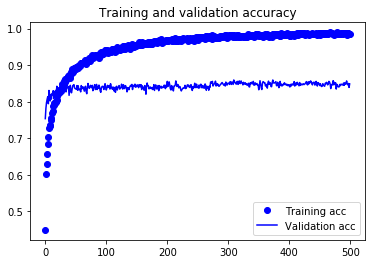

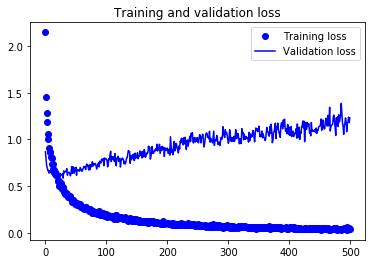

In [10]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

# 把每個訓練循環(epochs)的相關重要的監控指標取出來
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 取得整個訓練循環(epochs)的總次數
epochs = range(len(acc))

# 把"訓練準確率(Training acc)"與"驗證準確率(Validation acc)"的趨勢線形表現在圖表上
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# 把"訓練損失(Training loss)"與"驗證損失(Validation loss)"的趨勢線形表現在圖表上
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## save

In [13]:
submission = pd.read_csv('data/sampleSubmission.csv')

In [17]:
submission['Class'] = Y_test_pred

In [19]:
submission.to_csv('submission.csv', index=False)